In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
file_path = "dataset/data.xlsx"
data = pd.read_excel(file_path)
data.columns = data.columns.str.strip().str.replace('ï»¿', '', regex=False)
display(data.head())
print(data.isnull().sum())
print(data.info())
display(data.describe())

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB
None


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


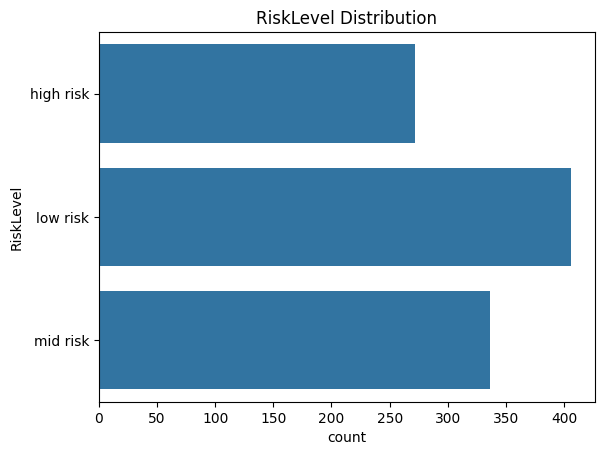

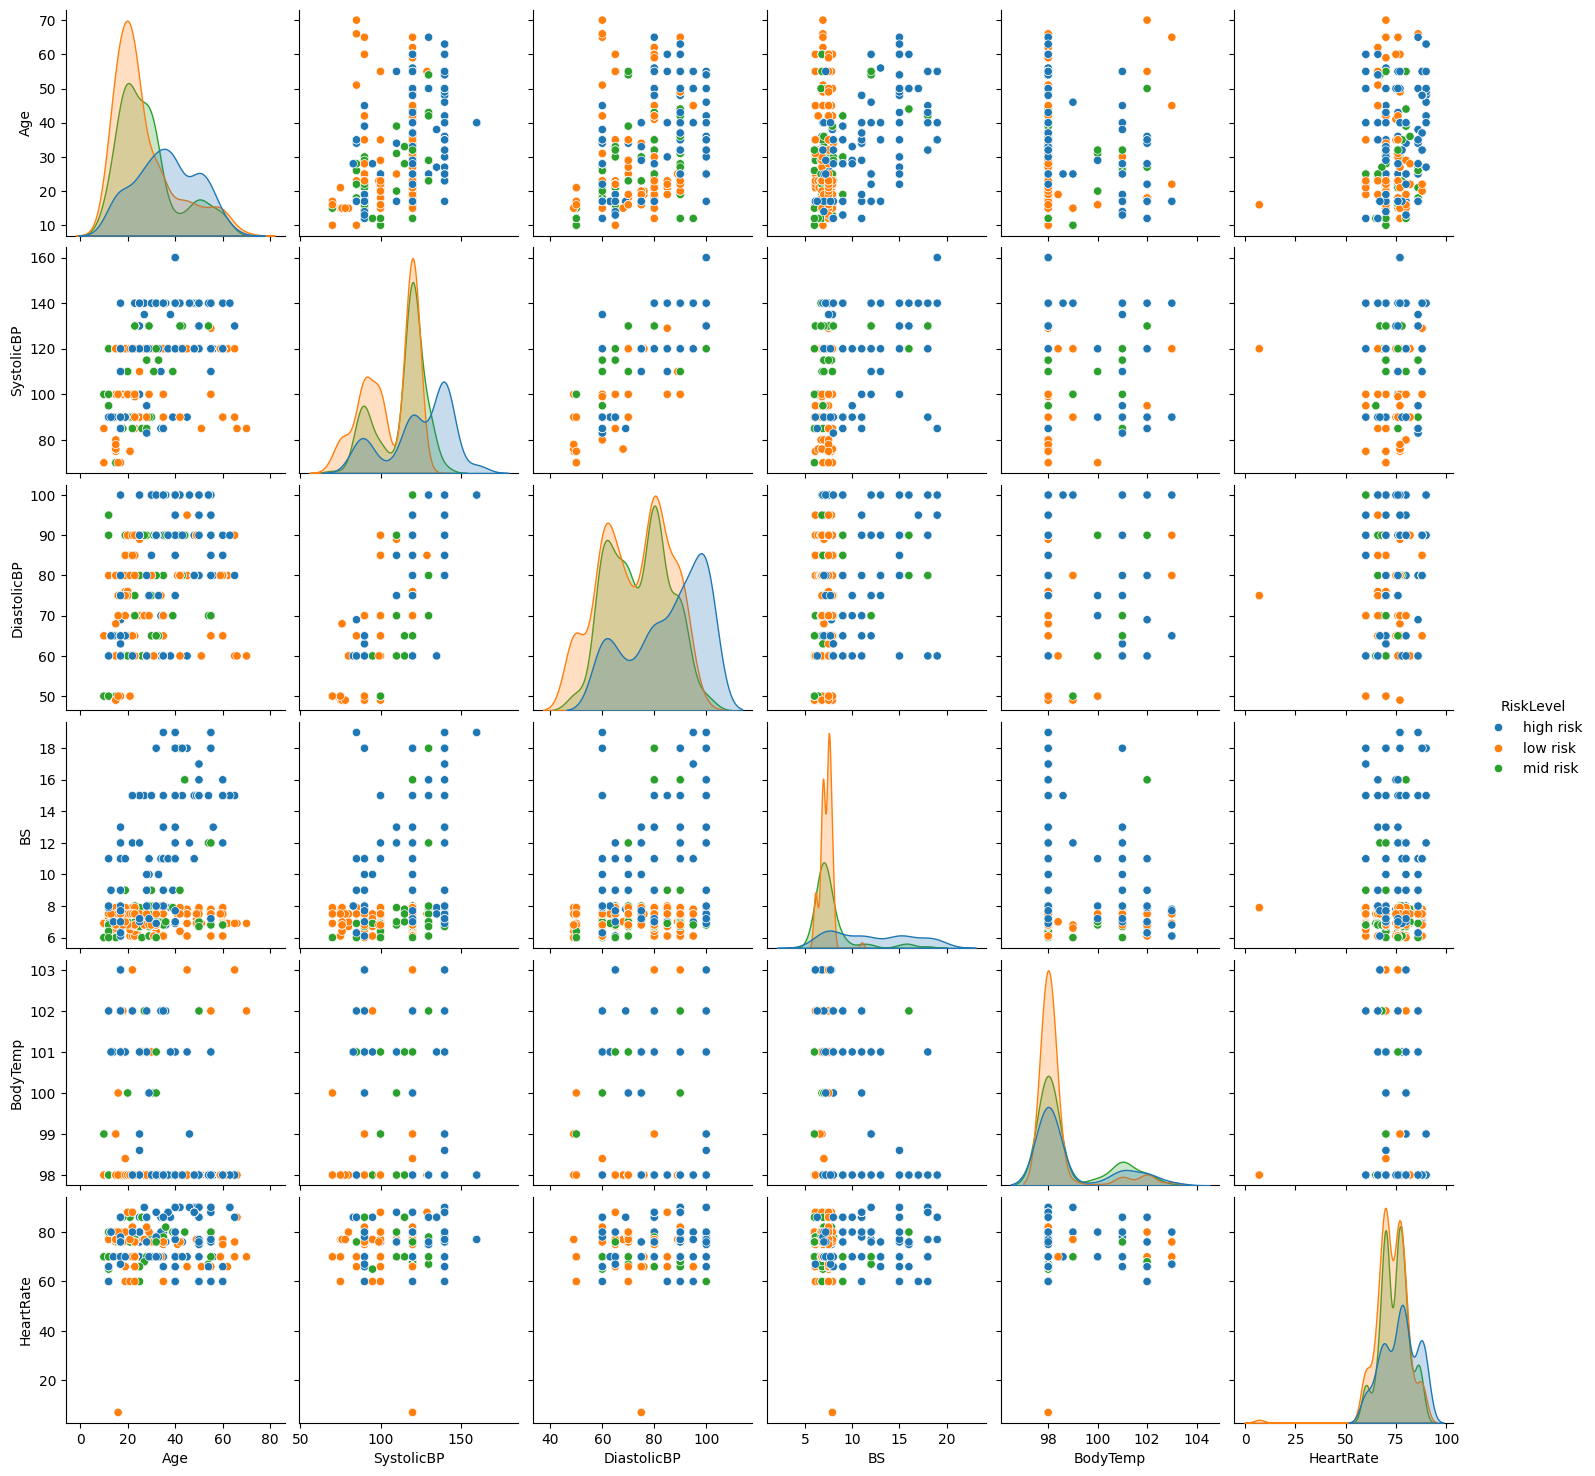

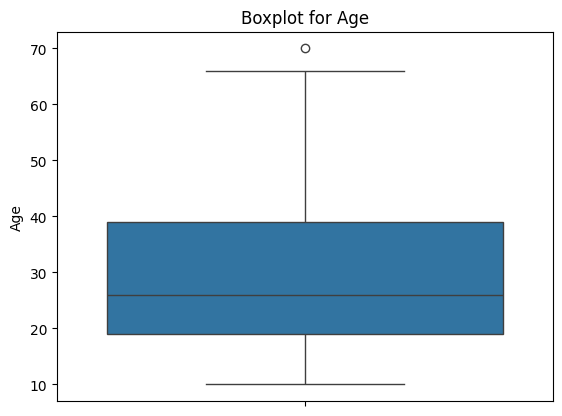

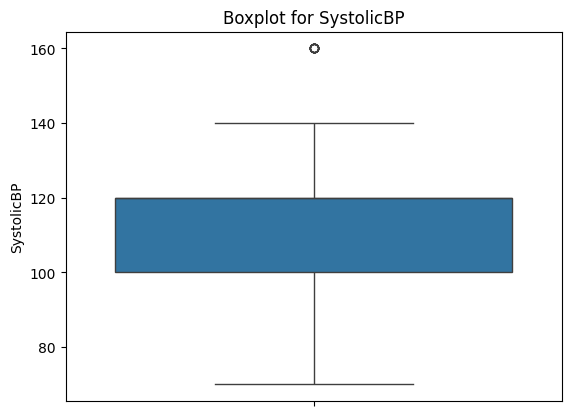

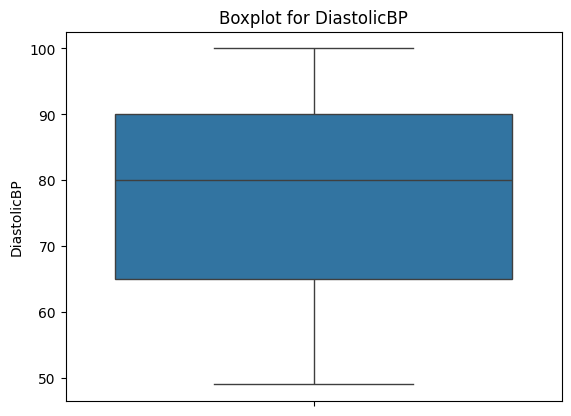

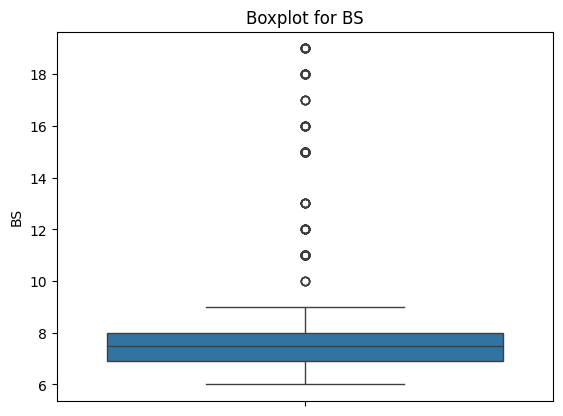

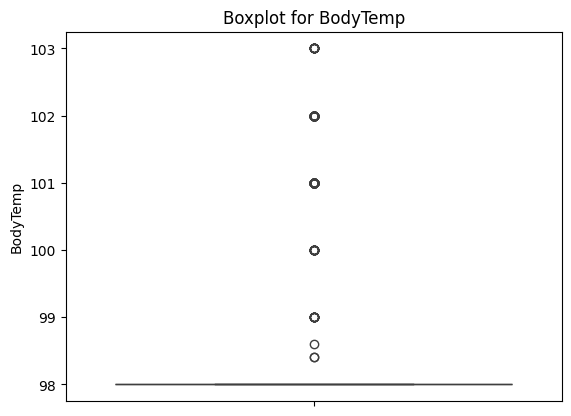

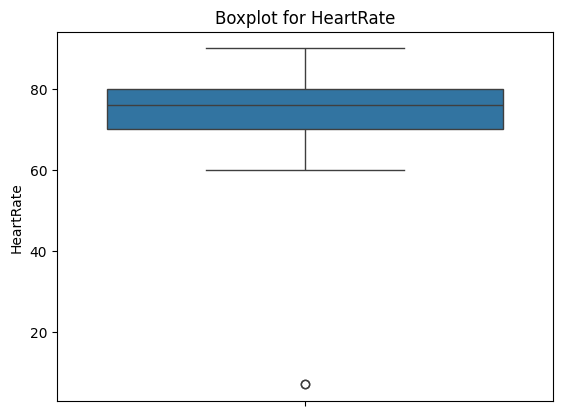

In [3]:
sns.countplot(data['RiskLevel'])
plt.title("RiskLevel Distribution")
plt.show()

sns.pairplot(data, hue='RiskLevel', diag_kind='kde')
plt.show()

features = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
for feature in features:
    sns.boxplot(data[feature])
    plt.title(f"Boxplot for {feature}")
    plt.show()

In [4]:
for feature in features:
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data[feature] >= lower_bound) & (data[feature] <= upper_bound)]
print(data.shape)

(600, 7)


In [5]:
label_encoder = LabelEncoder()
data['RiskLevel'] = label_encoder.fit_transform(data['RiskLevel'])

if 'Weight' in data.columns and 'Height' in data.columns:
    data['BMI'] = data['Weight'] / (data['Height'] ** 2)
else:
    data['BMI'] = 25

features = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate', 'BMI']
X = data[features]
y = data['RiskLevel']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(f"Training Set Size: {X_train.shape}")
print(f"Testing Set Size: {X_test.shape}")

Training Set Size: (480, 7)
Testing Set Size: (120, 7)


0.8666666666666667
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.88      0.86      0.87        58
           2       0.82      0.85      0.83        47

    accuracy                           0.87       120
   macro avg       0.90      0.88      0.89       120
weighted avg       0.87      0.87      0.87       120



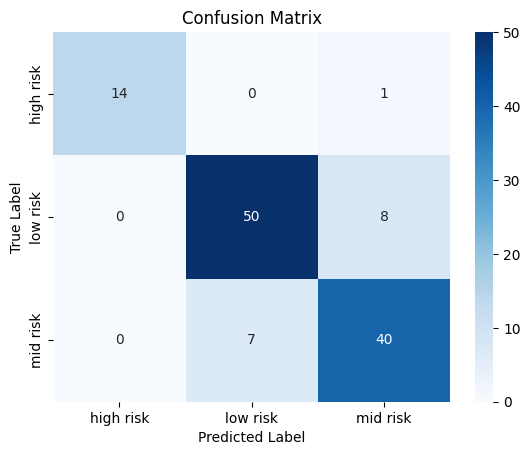

In [7]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [8]:
importances = best_rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(importance_df)

most_influential_feature = importance_df.iloc[0]
print(most_influential_feature['Feature'], most_influential_feature['Importance'])


       Feature  Importance
1   SystolicBP    0.270923
3           BS    0.244201
0          Age    0.189264
2  DiastolicBP    0.186506
5    HeartRate    0.109106
4     BodyTemp    0.000000
6          BMI    0.000000
SystolicBP 0.27092285201403127


In [9]:
model_file = "model/best_model.pkl"
with open(model_file, "wb") as file:
    pickle.dump(best_rf_model, file)

In [10]:
def predict_risk():
    user_input = {
        'Age': float(input("Age: ")),
        'SystolicBP': float(input("Systolic Blood Pressure (mm Hg): ")),
        'DiastolicBP': float(input("Diastolic Blood Pressure (mm Hg): ")),
        'BS': float(input("Blood Sugar Level: ")),
        'BodyTemp': float(input("Body Temperature: ")),
        'HeartRate': float(input("Heart Rate: ")),
        'BMI': float(input("BMI: "))
    }

    input_df = pd.DataFrame([user_input])
    input_scaled = scaler.transform(input_df)
    prediction = best_rf_model.predict(input_scaled)
    risk_level = label_encoder.inverse_transform(prediction)
    print("Risk Predicted:",risk_level[0])

predict_risk()

Age:  23
Systolic Blood Pressure (mm Hg):  90
Diastolic Blood Pressure (mm Hg):  60
Blood Sugar Level:  7.01
Body Temperature:  98
Heart Rate:  77
BMI:  20


Risk Predicted: low risk
